# OpenCLIP image classification demonstration

## Setup

In [ ]:
%pip install scikit-image

## Imports and global functions

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import torch
import open_clip
from open_clip import tokenizer
from PIL import Image
from skimage import data_dir
from utils.quant_openclip import quantize_model

descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "gravel": "a bunch of small stones used to build road",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "brick": "a brick to build wall and house",
    "coffee": "a cup of coffee on a saucer",
}

def make_prediction(quant=False, model_name="ViT-H-14", pretrained="laion2b_s32b_b79k"):
    model, _, preprocess = open_clip.create_model_and_transforms(
        model_name, pretrained=pretrained
    )
    if quant:
        model = quantize_model(model, model_name)
        
    model.eval()
    model = model.half().cuda()
    texts = descriptions.values()
    text_processed = tokenizer.tokenize(texts).cuda()
    imgs = []
    with torch.cuda.amp.autocast():
        for key in descriptions:
            img = Image.open(os.path.join(data_dir, f"{key}.png")).convert("RGB")
            img_preprocessed = preprocess(img).cuda().unsqueeze(0)
            img_embedding, text_embedding, _ = model(img_preprocessed, text_processed)
            probs = (100 * img_embedding @ text_embedding.T).softmax(dim=-1)
            imgs.append((img, probs))
            del img_embedding
            del text_embedding
            torch.cuda.empty_cache()
            gc.collect()
    return imgs


def plot_classification(imgs):
    gs_kw = dict(width_ratios=[1, 1, 1, 1], height_ratios=[3, 1, 3, 1])
    fig, axes = plt.subplot_mosaic(
        """
        ABCD
        EFGH
        JKLM
        NOPQ
        """,
        gridspec_kw=gs_kw,
        figsize=(12, 6),
        layout="constrained",
    )
    i, j, k = 0, 0, 0
    for _, ax in axes.items():
        if (i // 4) % 2 == 0:
            ax.axis("off")
            ax.imshow(imgs[j][0])
            j += 1
        else:
            ax.bar(descriptions.keys(), imgs[k][1].squeeze().detach().cpu().numpy())
            ax.tick_params(axis="x", labelrotation=45)
            ax.set_ylabel("Probability (%)")
            k += 1
        i += 1
    fig.show()


## Run classification using open_clip model

In [2]:
# make_prediction() requires a lot of GPU memory to run.
# Restart the kernel if you get OOM error.
imgs = make_prediction()

/tmp/ipykernel_29431/4238241088.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


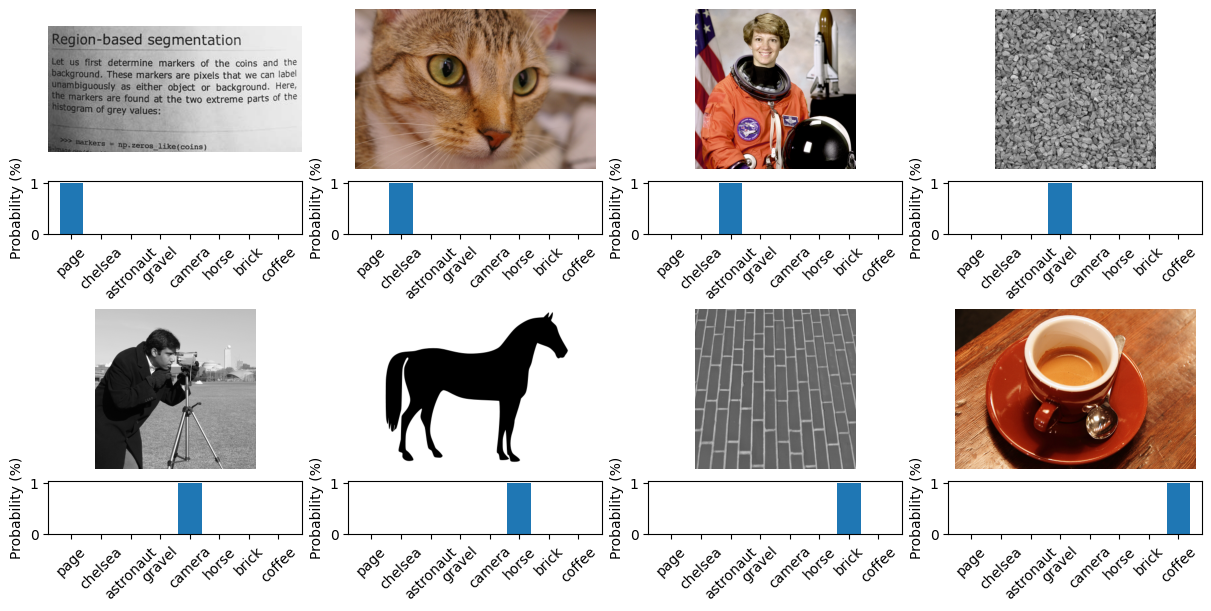

In [3]:
plot_classification(imgs)

## Run classification using HHQ quantized open_clip model

In [2]:
# make_prediction() requires a lot of GPU memory to run.
# Restart the kernel if you get OOM error.
imgs = make_prediction(quant=True)

TextModal-L: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 43.05it/s]


/tmp/ipykernel_25818/796304792.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


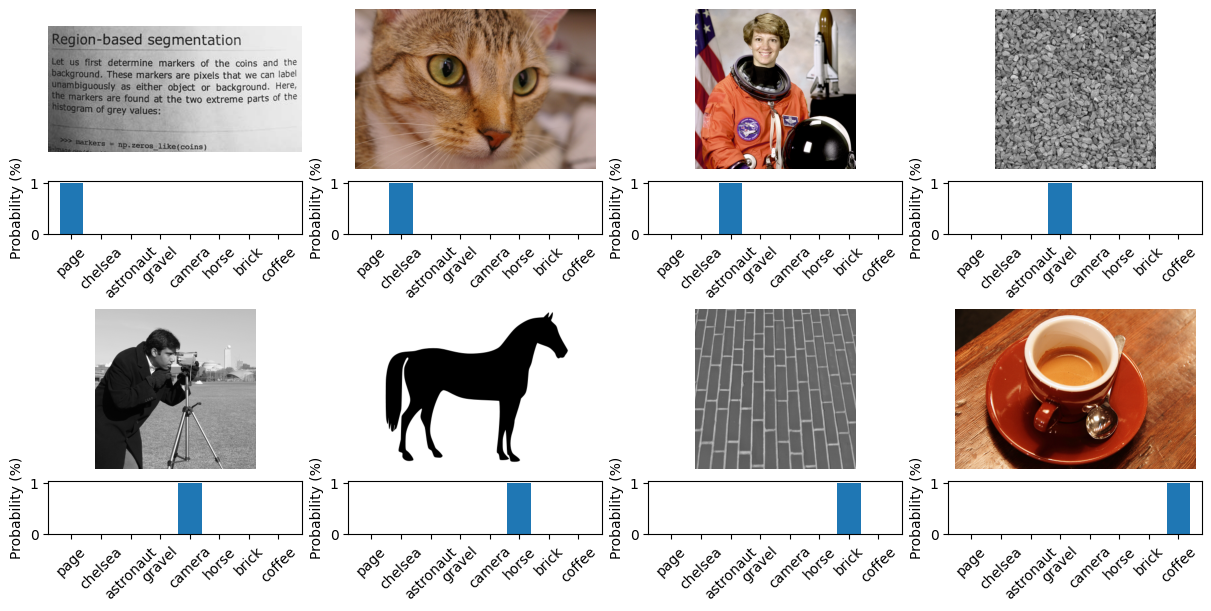

In [3]:
plot_classification(imgs)

In [4]:
descriptions.values()

dict_values(['a page of text about segmentation', 'a facial photo of a tabby cat', 'a portrait of an astronaut with the American flag', 'a bunch of small stones used to build road', 'a person looking at a camera on a tripod', 'a black-and-white silhouette of a horse', 'a brick to build wall and house', 'unknown description'])